# Bank Transaction Classifier
## Final Analysis

In [100]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score

# Area Under the Precision-Recall Curve 
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve
from sklearn.metrics import f1_score, auc, average_precision_score

### Import data

In [2]:
%%time

# import training and test data
PATH_train = (r'assets\santander\train_clean.csv')
PATH_test = (r'assets\santander\test_clean.csv')

train_data = pd.read_csv(PATH_train, index_col=0)
test_data = pd.read_csv(PATH_test, index_col=0)

df_train = pd.DataFrame(train_data)
df_test = pd.DataFrame(test_data)

display(df_train.head())

,target,0,1,2,3,4,5,6,7,8,...,76,77,78,79,80,81,82,83,84,85
0,0,-0.027133,0.142831,-0.111250,0.143562,0.004239,-0.071815,0.337378,0.218159,0.189081,...,-0.005709,-0.129544,-0.099462,-0.012352,-0.045079,-0.046897,-0.043987,0.064105,-0.013727,-0.128452
1,0,0.150981,0.330123,0.089315,-0.192914,-0.170878,-0.151223,0.007596,-0.114647,-0.097730,...,0.040397,-0.153714,0.253848,0.214468,-0.036794,-0.130433,-0.061869,-0.079233,0.044787,-0.055746
2,0,0.054292,0.222968,0.016821,0.262956,0.025092,0.004047,0.179983,0.136441,0.014935,...,-0.010997,0.113560,0.022930,0.047859,0.127231,0.139168,-0.000719,-0.066721,0.103822,0.070443
3,0,-0.030226,-0.150338,0.325219,-0.326716,-0.101473,0.108594,-0.067955,-0.268760,-0.112723,...,-0.134556,0.025619,-0.177989,-0.049176,0.234301,-0.127792,0.001177,-0.036717,0.151785,-0.106692
4,0,0.015250,-0.142634,-0.316099,0.323023,0.001129,0.059206,-0.077948,0.238951,0.193648,...,0.192886,-0.106981,-0.200711,0.092928,0.127197,-0.018342,-0.071950,-0.000997,0.005745,-0.377629


Wall time: 6min 33s


### Reduce memory usage

In [3]:
# plot confusion matrix
from sklearn.metrics import confusion_matrix
import itertools

#
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        1#print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Train, test, split

In [4]:
#
data = df_train.drop('target', axis=1)
target = df_train['target']
features = [c for c in data.columns]
#
X_train = data
y_train = target
X_test = df_test
y_test = pd.DataFrame()

## Final Model
### Optimized Light Gradient Boosting

In [5]:
# hard core optimized model parameters
best_params = {# controls verbosity
               'verbose': 1,
               # Max number of leaves in one tree
               'num_leaves': 62,
               # Number of boosting iterations
               'n_estimators': 1000,
               # Minimal sum hessian in one leaf. Can be used to deal with over-fitting
               # Hessian matrix is a square matrix of second-order partial derivatives
               # of a scalar-valued function.
               # It describes the local curvature of a function of many variables
               'min_sum_hessian_in_leaf': 1e-05,
               # Minimal number of data in one leaf. Can be used to deal with over-fitting
               'min_data_in_leaf': 20,
               # Limit the max depth for tree model. Tree still grows leaf-wise.
               'max_depth': 11,
               # Max number of bins that feature values will be bucketed in.
               # Small number of bins may reduce training accuracy
               # but may increase general power (deal with over-fitting)
               'max_bin': 255,
               # Frequency for bagging. Performs bagging at every k iteration
               'bagging_freq': 0,
               # This will randomly select (subsample) part of data without resampling.
               # Can be used to speed up training and deal with over-fitting
               'bagging_fraction': 0.625
              }

In [6]:
# instantiate Light GBM Classifier
from lightgbm import LGBMClassifier
Model = LGBMClassifier(**best_params, random_state=42)
Model.fit(X_train, y_train)
# Test the classifier and get the prediction
y_pred = Model.predict(X_train)
# metrics
model_metrics = {}
model_metrics['Accuracy score'] = accuracy_score(y_train, y_pred)
model_metrics['Mean absolute error'] = mean_absolute_error(y_train, y_pred)
model_metrics['Mean squared error'] = mean_squared_error(y_train, y_pred)

### Confusion matrix

Recall metric in the train dataset: 98.6309212793632%
Precision metric in the train dataset: 98.6016010901039%


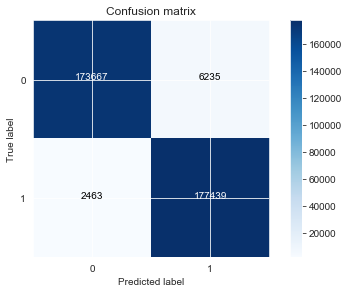

In [111]:
#y_pred_train = Model.predict(X_train)
#cnf_matrix = confusion_matrix(y_train, y_pred_train)
cnf_matrix = confusion_matrix(y_train, y_pred)

model_metrics['Train Recall metric'] = 100*cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1])
print("Recall metric in the train dataset: {}%".format(model_metrics['Train Recall metric'])
     )
model_metrics['Train Precision metric'] = 100*cnf_matrix[0,0]/(cnf_matrix[0,0]+cnf_matrix[1,0])
print("Precision metric in the train dataset: {}%".format(model_metrics['Train Precision metric'])
     )
# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix , classes=class_names, title='Confusion matrix')
plt.savefig('assets\model_conf_train.png')
plt.show()

### ROC curve

ROC-AUC: 0.976


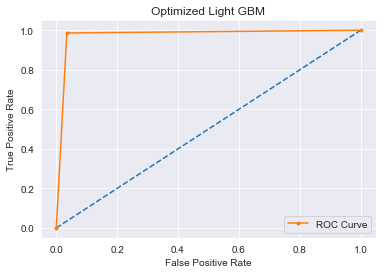

In [110]:
# calculate AUC
model_metrics['ROC-AUC'] = auc_score = roc_auc_score(y_train, y_pred)
print('ROC-AUC: %.3f' % model_metrics['ROC-AUC'])
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_train, y_pred)

# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.', label='ROC Curve')
plt.title('Optimized Light GBM')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.savefig('assets\model_ROC.png')
plt.show()

### Precision-recall curve

f1=0.976 auc=0.980 ap=0.960


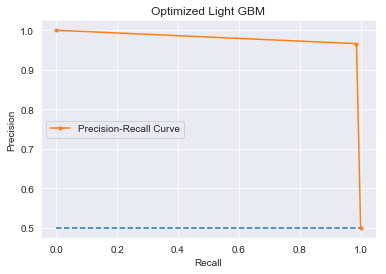

In [109]:
# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_train, y_pred)
# calculate F1 score
model_metrics['F1 score'] = f1_score(y_train, y_pred)
# calculate precision-recall AUC
model_metrics['Precision-Recall AUC'] = auc(recall, precision)
# calculate average precision score
model_metrics['Average Precision'] = average_precision_score(y_train, y_pred)
print('f1=%.3f auc=%.3f ap=%.3f' % (model_metrics['F1 score'],
                                    model_metrics['Precision-Recall AUC'],
                                    model_metrics['Average Precision']))

# plot no skill
plt.plot([0, 1], [0.5, 0.5], linestyle='--')
# plot the precision-recall curve for the model
plt.plot(recall, precision, marker='.', label='Precision-Recall Curve')
plt.title('Optimized Light GBM')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.savefig('assets\model_precision_recall.png')
plt.show()

### Feature importance

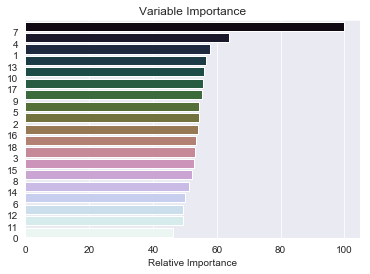

In [108]:
# view top features
feature_importance = Model.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance[:19])
pos = np.arange(sorted_idx.shape[0]) + 0.5

#plt.subplot(1,2,2)
#plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.figure(figsize=(6,4))
sns.barplot(x=feature_importance[sorted_idx],
            y=pos[::-1],
            orient='h',
            palette="cubehelix",
           )

plt.yticks(pos, data.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.savefig('assets\model_var_import.png')
plt.show()

In [ ]:
# sort top features
top_features = np.where(feature_importance > 57)
top_features = data.columns[top_features].ravel()
print(top_features)

### Metrics

In [ ]:
# view metrics
print('Optimized Light GBM')
for i in model_metrics.items():
    print(i)

## Analysis

## Conclusion
This data set was created to predict which bank customers will make a transaction, which we were able to predict with 95.23% success rate (ROC AUC score).

This model can be applied in a business setting to determine which customers to direct specific services towards. By predicting which customers will make a transaction, businesses can advertise services related to those transactions directly to the customers making them. Businesses could also use this model to more intuitively anticipate the needs of customers by understanding what transactions they will make.

This type of model could be more broadly applied outside the field of financial transactions and be used to predict customer conversion rates in other settings, such as retail, advertising click-through rates, or new customer sign up rates. The model would just require filed-specific features.

Potential shortcomings of this model are the anonymous nature of the features. Both from the unlabeled nature of the data provided and from principal component analysis. The anonymous features can limit feature engineering; without context it’s difficult to determine which factors to manipulate. The lack of labels also prevents meaningful interpretation of the results. After principal component analysis it’s difficult to interpret the model’s top features.  This prevents any possible recommendations or business strategy decisions that could be gained from knowledge of feature efficacy. 

A possible solution to the anonymity of this model could be to use deep learning methods and apply a clustering algorithm for feature engineering. A more advanced approach such as this might create a more meaningful model that could be more versatile in its application.